## Set file to analysis

In [115]:
import json
from tqdm import tqdm
from pathlib import Path
data_file = "./train_mix.jsonl"
data_file = Path(data_file)
output_dir = "./data_dist"
output_dir = Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Context length Distribution

In [116]:
with open(data_file.with_suffix(".format_v2.json"), 'r') as f:
    data = json.load(f)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
input_lens = [len(tokenizer.encode(item["input"]))
                for item in tqdm(data, desc="Counting input length")]
output_lens = [len(tokenizer.encode(item["output"]))
                for item in tqdm(data, desc="Counting output length")]
total_lens = [x + y for x, y in zip(input_lens, output_lens)]


Counting output length: 100%|██████████| 48277/48277 [00:21<00:00, 2246.18it/s]


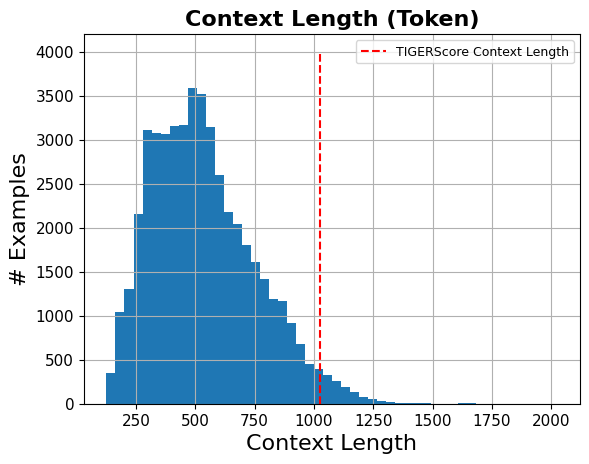

In [148]:
from matplotlib import pyplot as plt
import numpy as np
# Calculate the histogram
max_render_len = 2048
hist, bins = np.histogram([x for x in total_lens if x < 2048], bins=50, density=False)

# Calculate the width of each bin
bin_width = bins[1] - bins[0]

# Create a bar plot
plt.bar(bins[:-1], hist, align='center', width=bin_width)

plt.plot([1024, 1024], [0, 4000], 'r--', label='TIGERScore Context Length')

# Adding labels and title
plt.xlabel('Dataset I/O Length (Token)', fontsize=16)
plt.ylabel('# Examples', fontsize=16)
plt.title('Context Length', fontsize=16, fontweight='bold')
plt.legend(fontsize=9)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# Optionally, add a grid for better readability
plt.grid(True)

# Show the plot
# plt.show()
plt.savefig(output_dir / "train_mix.format_v2.context_length_distribution.png", bbox_inches='tight')

## Count Distribution of number of errors

In [118]:
import regex as re
from collections import Counter, defaultdict

with open(data_file, 'r') as f:
    data = [json.loads(line) for line in f]
tasks = set([item["task"] for item in data])
data_elements_map = defaultdict(list)
for item in tqdm(data, "Extracting data elements"):
    # error_locations = re.findall(
    #     r'(?<=Error location \d+:)[\n ]*.*(?=\n|$)', item["errors"])
    error_aspects = re.findall(
        r'(?<=Error aspect \d+:)[\n ]*.*(?=\n|$)', item["errors"])
    # explanations = re.findall(
    #     r'(?<=Explanation \d+:)[\n ]*.*(?=\n|$)', item["errors"])
    severities = re.findall(
        r'(?<=Severity \d+:)[\n ]*.*(?=\n|$)', item["errors"])
    score_reductions = re.findall(
        r'(?<=Score reduction \d+:)[\n ]*.*(?=\n|$)', item["errors"])
    valid_scores_idxs = [i for i, x in enumerate(score_reductions) if x.strip("\n ").lower() != "n/a"]
    valid_scores = [score_reductions[i] for i in valid_scores_idxs]
    valid_severities = [severities[i] for i in valid_scores_idxs]
    # valid_explanations = [explanations[i] for i in valid_scores_idxs]
    valid_error_aspects = [error_aspects[i] for i in valid_scores_idxs]
    # valid_error_locations = [error_locations[i] for i in valid_scores_idxs]
    valid_scores = [float(x.strip("\n ")) for x in valid_scores]
    # data_elements_map["error_location"].extend(valid_error_locations)
    data_elements_map["error_aspect"].append(valid_error_aspects)
    # data_elements_map["explanation"].extend(valid_explanations)
    data_elements_map["severity"].append(valid_severities)
    data_elements_map["score_reduction"].append(valid_scores)
    data_elements_map["task"].append(item["task"])
    data_elements_map["num_errors"].append(len(valid_scores))

Extracting data elements: 100%|██████████| 48277/48277 [00:08<00:00, 5886.26it/s]


Counter({1: 2915, 3: 2170, 2: 1714, 4: 916, 0: 881, 5: 234, 6: 34, 7: 1, 8: 1})
Counter({2: 3289, 3: 3020, 1: 1956, 0: 1286, 4: 1110, 5: 42, 6: 1})
Counter({1: 4237, 2: 2084, 3: 1354, 0: 727, 4: 191, 5: 21})
Counter({2: 2377, 1: 1946, 3: 1208, 0: 943, 4: 830, 5: 45, 6: 2})
Counter({2: 3113, 3: 760, 1: 684, 0: 562, 4: 422, 5: 16})
Counter({1: 2299, 2: 1401, 3: 1242, 0: 1167, 4: 1015, 5: 55, 6: 5, 7: 1})


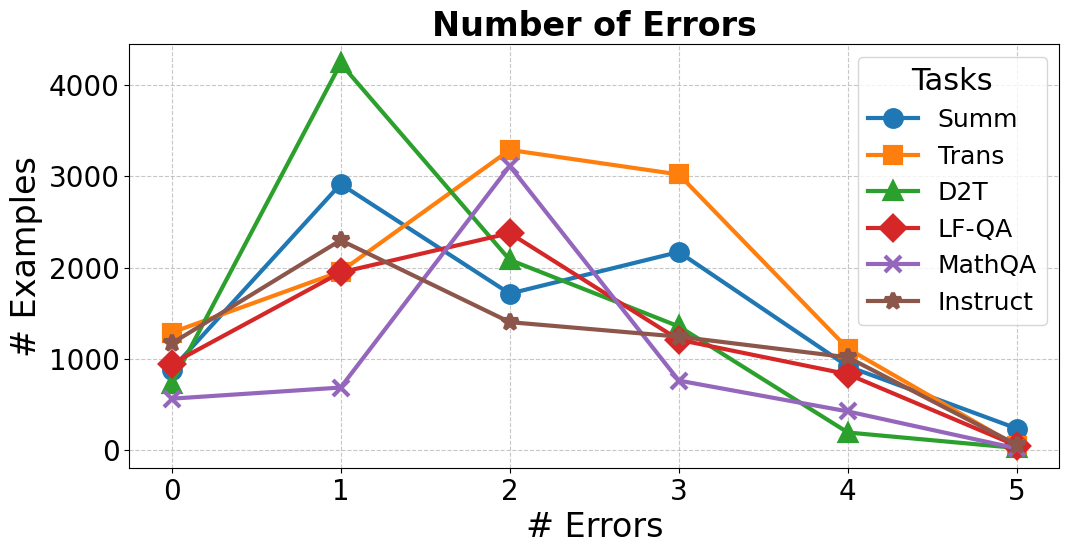

In [147]:
# draw number of errors distribution per task
data = {}

task_name_abb_map = {
    "summarization": "Summ",
    "translation": "Trans",
    "data2text": "D2T",
    "long-form QA": "LF-QA",
    "mathQA": "MathQA",
    "instruction-following": "Instruct",
}
for task in task_name_abb_map.keys():
    num_errors = Counter([data_elements_map["num_errors"][i] for i, x in enumerate(data_elements_map["task"]) if x == task])
    print(num_errors)
    data[task_name_abb_map[task]] = [num_errors[i] for i in range(0, 6)]
    

# Creating the plot
plt.figure(figsize=(12, 5.5))

markers = ['o', 's', '^', 'D', 'x', '*']

for (thing, values), marker in zip(data.items(), markers):
    plt.plot(values, marker=marker, label=thing, markersize=12, linewidth=3, markeredgewidth=3)


# Adding titles and labels
plt.title('Number of Errors', fontsize=24, fontweight='bold')
plt.xlabel('# Errors of per instance', fontsize=24)
plt.ylabel('# Examples', fontsize=24)
plt.legend(title="Tasks", title_fontsize='22', fontsize='18')

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Enhancing the tick labels for better readability
plt.xticks(range(6), fontsize=20)
plt.yticks(fontsize=20)

# Show the plot
plt.savefig(output_dir / f"{data_file.stem}.num_errors_distribution.png", bbox_inches='tight')

## Number of Aspects distribution

In [120]:
# draw number of errors distribution per task
plot_data = {}


for task in task_name_abb_map.keys():
    task_severities = []
    for i, x in enumerate(data_elements_map["task"]):
        if x == task:
            task_severities.extend([
                x.strip() for x in data_elements_map["severity"][i] if any([y in x.lower() for y in ["major", "minor"]])
            ])
    severity_counter = Counter(task_severities)
    plot_data[task_name_abb_map[task]] = [severity_counter[x] for x in ["Major", "Minor"]]
plot_data

{'Summ': [12170, 5724],
 'Trans': [10595, 11655],
 'D2T': [7434, 5885],
 'LF-QA': [10026, 3855],
 'MathQA': [10112, 846],
 'Instruct': [9530, 3667]}

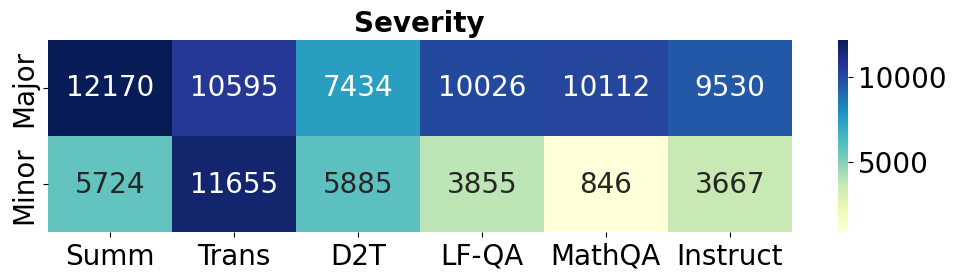

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
# Preparing data for heatmap
categories = list(plot_data.keys())
values1 = [plot_data[cat][0] for cat in categories]
values2 = [plot_data[cat][1] for cat in categories]

# Creating a DataFrame for the heatmap
import pandas as pd

df = pd.DataFrame({'Tasks': categories, 'Major': values1, 'Minor': values2})
df = df.set_index('Tasks')
df=df.T

# Plotting the heatmap
plt.figure(figsize=(12, 2.5))

# Removing the y-axis label
heatmap = sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", annot_kws={"size": 20})
plt.title("Severity", fontsize=20, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('')
plt.xlabel('')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.savefig(output_dir / f"{data_file.stem}.severity_distribution.png", bbox_inches='tight')